# Main Notebook

**This notebook has all the components of developed RAG model, it also addresses all the requirements, including responses to the final question**

In [61]:
import re
from nltk.tokenize import sent_tokenize, word_tokenize
import os
import nltk
from typing import List, Tuple
from tqdm import tqdm
import hashlib
import pandas as pd


nltk.download('punkt', quiet=True)

True

# Data Preprocessing

Inputting the text file and setting the max_length ensures that we do not have super long sentences. That often result from converting HTML to text. This is also mentioned on the Kaggle page for this dataset.
    

In [62]:

def clean_text(text, max_length=40):
    #input the text file and max_length is making sure we do not have super long sentences which are mostly because of conver
    # converting from html to text AS IT is mentioned in kaggle page for this dataset too
    try:
        # extracting sentences using nltk library
        sentences = sent_tokenize(text)
        cleaned_sentences = []
        
        for sentence in sentences:
            # some customized cleaning process after looking at dozons of text file in the dataset
            cleaned_sentence = re.sub(r'\{.*?\}|\[.*?\]|\(.*?\)|\\n|•|<.*?>|http\S+|-{2,}', '', sentence)
            cleaned_sentence = re.sub(r'by [\w\s|]+ on \d+ [A-Z]+ \d+ \|.*? Comments \|', '', cleaned_sentence)  
            # some phareses that seem to be noise from html to text, so i further clean them to make sure that data has a good quality
            patterns = [
                r'\b(?:Español|日本語|한국어|Amazon MAP|AWS Services Used|Sr\. Program Manager|mso-pagination|ol|mso-bidi-font-family|Cambria|Thai|Portuguese|French|Deutsch|Italian|Chinese|Russian|Roman|mso-style-parent|Get Started|Contact Sales|font-size|Wingdings)\b',
                r'mso-[\w\-]+:[\w\-]+;?',
                r'@\w+-face',
                r'\bmso-\w+-props\b',
                r'margin:[\d\w]+;',
                r'panose-[\d ]+;',
                r'mso-\w+-font-family',
                r'mso-font-charset:[\d]+;',
                r'mso-default-props:[\w]+;',
                r'font-family:Cambria;',
                r'\b\d{4}\b',
                r'\bmso-\w+-qformat\b',
                r'mso-\w+-size:[\d\w]+;',
                r'mso-[\w-]+:yes;',
                r'[\[\]]'
            ]
            
            for pattern in patterns:
                cleaned_sentence = re.sub(pattern, '', cleaned_sentence)
            
            # remove extra spaces + lowering characters
            cleaned_sentence = re.sub(r'\s+', ' ', cleaned_sentence).strip().lower()
            
            # word tokenize the sentence to make sure the chunking is consistent
            tokens = word_tokenize(cleaned_sentence)
            
            # making sure that the length of any setences is not more a certain length
            for i in range(0, len(tokens), max_length):
                chunk = tokens[i:i+max_length]
                chunk_sentence = ' '.join(chunk)
                # add a period if the sentence does not have
                if not chunk_sentence[-1] in '.!?':
                    chunk_sentence += '.'
                cleaned_sentences.append(chunk_sentence)
                
        cleaned_text = ' '.join(cleaned_sentences)
        
        return cleaned_text
    except Exception as e:
        print(f"An error occurred: {e}")
        return text  # Return original text if an error occurs

In [63]:

directory_path = 'data/'

files = os.listdir(directory_path)
txt_files = [file for file in files if file.endswith('.txt')]
# reading the all files and preprocess them and then save them
for file in txt_files:
    with open(f'data/{file}', 'r', encoding='utf-8') as infile, open(f'processed/{file}', 'w', encoding='utf-8') as outfile:
        text = infile.read()
        cleaned_text = clean_text(text, max_length=64)
        outfile.write(cleaned_text)

# Chunking text files

- Creating a chunking function making sure there is an overlap between them, 
- Chunking is sentence friendly, does not chunk in the middle of sentenc
    

In [64]:
# creating a chunking function making sure there is an overlap between them, 
# chunking is sentence friendly, does not chunk in the middle of sentence

def generate_hash_id(content):
    return hashlib.md5(content.encode()).hexdigest()

def count_tokens_in_file(text):
    return len(nltk.word_tokenize(text))

def chunk_text(text, max_tokens=128, overlap=20, min_tokens=40):
    words = text.split()
    chunks = []
    current_chunk = []
    current_chunk_tokens = 0

    for i, word in enumerate(words):
        current_chunk.append(word)
        current_chunk_tokens = count_tokens_in_file(' '.join(current_chunk))

        if current_chunk_tokens >= max_tokens:
            chunks.append(' '.join(current_chunk))
            overlap_start = max(0, len(current_chunk) - overlap)
            current_chunk = current_chunk[overlap_start:]
            current_chunk_tokens = count_tokens_in_file(' '.join(current_chunk))

    #  the last chunk
    if current_chunk:
        if current_chunk_tokens < min_tokens and chunks:
            # we should merge with previous chunk if it's too small
            chunks[-1] += ' ' + ' '.join(current_chunk)
        else:
            chunks.append(' '.join(current_chunk))

    return chunks

directory_path = 'processed/'
files = os.listdir(directory_path)
txt_files = [file for file in files if file.endswith('.txt')]
chunks = []

for file in tqdm(txt_files, desc="Processing files"):
    with open(f'{directory_path}/{file}', 'r', encoding='utf-8') as infile:
        text = infile.read()
        chunk_per_file = chunk_text(text, max_tokens=128, overlap=20, min_tokens=40)
        chunks.extend(chunk_per_file)

# Print statistics about chunk sizes
chunk_sizes = [count_tokens_in_file(chunk) for chunk in chunks]
print(f"Total chunks: {len(chunks)}")
print(f"Average chunk size: {sum(chunk_sizes) / len(chunks):.2f} tokens")
print(f"Maximum chunk size: {max(chunk_sizes)} tokens")

data = [{"chunk": chunk, "chunk_id": f"cid_{generate_hash_id(chunk)}"} for chunk in chunks]
df = pd.DataFrame(data)

Processing files: 100%|███████████████████████| 347/347 [07:12<00:00,  1.25s/it]


Total chunks: 5118
Average chunk size: 125.78 tokens
Maximum chunk size: 166 tokens


In [9]:
df.to("chunked_data.csv", index=False)
df

,chunk,chunk_id
0,aws for industries the next frontier : generat...,cid_99585cb394bc4cfa3ae549a000df11df
1,commonly referred to as foundation models . in...,cid_b7252a696b2e4eebef7b6e014d729846
2,contracts . while traditional ai tools can hel...,cid_4d9982f7932727dcbb406eb5b8d1b19c
3,"analysis , and extend the power of ai in finan...",cid_99f83f5cef45eef73b87f578f4e7146b
4,"at scale , and how to get started with generat...",cid_b76eb8c7de1aeb099c467fd523f5911c
...,...,...
5113,"aws , ” manoharan says , “ we can strike the r...",cid_480d67c1f6e3625c36660dcdde8f5c3e
5114,easier . snap optimizes cost savings while sto...,cid_65aafbb0ec2a6490ba0f150f1671431b
5115,opportunity | optimizing storage by migrating ...,cid_6d4f252ac92be3f623a5848673239315
5116,determine if amazon s3 glacier instant retriev...,cid_31d6370a4eede0d1c4b2984f54a65e0c


In [1]:
import pandas as pd
df = pd.read_csv("chunked_data.csv")

# Loading the finetuned embedding model
First, I made a dataset to fine-tune the embedding models and then picked the best one. Here’s how I made the data:
1. I combined two datasets. For the first part, I asked the model to create a question from a chunk of text. Then, I made positive pairs using the question and the chunk itself.
2. For the second part, I used GPT-3.5 Turbo to create a question for each chunk of text. Then, I asked GPT-3.5 again to find sentences that answer the question, creating a question and anchor pair.

Finally, I concatenated these two datasets. I did this make sure the embedding models learn to associate questions with relevant answers, enhancing their performance in understanding and retrieving information based on the given dataset.

Then I finetuned the model based on contrastive loss as I have both postive pairs and negative example. More importantly, I added a dense layer (keep dim to be the same original one) + L2 projection layer as the final layer for the embedding model, and start training model for 5 epochs. For more insight on the results please see this file: embedding_models.ipynb





The SimCLR loss for contrastive learning for sentence embeddings is defined as follows:

L_SimCLR = -log[ exp(sim(h_i, h_j) / τ) / Σ(k=1 to 2N) 1[k ≠ i] * exp(sim(h_i, h_k) / τ) ]

Where:
- h_i and h_j are the embeddings of the positive pair.
- sim(h_i, h_j) is the cosine similarity between h_i and h_j.
- τ (tau) is a temperature parameter.
- 2N is the total number of samples in the batch.
- 1[k ≠ i] is an indicator function equal to 1 if k ≠ i, otherwise 0.

In [2]:
# loading the contrastived-based trained model and get the vectors

import torch
from sentence_transformers import SentenceTransformer
import torch.nn as nn
device="cuda" if torch.cuda.is_available() else "cpu" 

class ProjectionLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(ProjectionLayer, self).__init__()
        self.dense = nn.Linear(in_dim, out_dim)
    
    def forward(self, x):
        x = self.dense(x)
        x = nn.functional.normalize(x, p=2, dim=1)  # L2 normalization
        return x

sentence_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)
projection_layer = ProjectionLayer(
    in_dim=sentence_model.get_sentence_embedding_dimension(),
    out_dim=sentence_model.get_sentence_embedding_dimension()
)
#final model that has been used for vectorizing the chunks
sentence_model._first_module().auto_model.add_module("projection_layer", projection_layer)
sentence_model.load_state_dict(torch.load("mini_model_finetuned_projected/model_state_dict.pt"))


chunks = df['chunk'].tolist()
vectors = sentence_model.encode(chunks, show_progress_bar=True)
df['vector'] = vectors.tolist()

/home/alilotfi/anaconda3/envs/myenv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-07-08 07:12:19.283077: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-08 07:12:20.355814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/alilotfi/anaconda3/envs/myenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to f

Batches:   0%|          | 0/160 [00:00<?, ?it/s]

In [3]:
df.to_csv("embedding.csv", index=False)

In [4]:
# checking if the magnitude of each vector is 1
import numpy as np
vec = df.at[1, 'vector']
l2_norm = np.linalg.norm(vec)
print("L2 norm:", l2_norm)


L2 norm: 0.9999999977780809


In [5]:
# for any vector in the df, the vectors have norm 1, as expected, since I further finetuned the model with a dense layer added and also a projection head that normalize the vector

## Vector Database
Finally, to help my RAG model find information quickly, I made a special type of database called a vector database using a library named Faiss. This library helps the model retrieve relevant information efficiently.

# Details: 
I used a fine-tuned MiniLM model (which I chose after comparing with another model based on cost and performance) for converting documents into vectors. I enhanced this model with a dense layer + projection layer and finetuned it. I create a dataset for finetuning using the text provied by kaggle the given dataset. The created dataset includes positive and negative pairs for each anchor (or query)

After creating these vectors, I used Faiss to build a vector database. This database helps me quickly find the most relevant documents when a customer query comes in.


**Vector Store Used**: **Faiss**

### Steps:


- I used the finetuned MiniLM model to transform documents into vector representations.
- I used Faiss to store and manage these vectors efficiently.
- When a query comes in, I convert it to a vector using the same MiniLM model.
- I use Faiss to find the most similar documents to the query.



In [7]:
import faiss
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np

vectors = np.array(df['vector'].tolist()).astype('float32')

# no need to normalize as vectors already have norm one
# faiss.normalize_L2(vectors)
vector_dim = vectors.shape[1]
index = faiss.IndexFlatIP(vector_dim) 

index.add(vectors)

faiss.write_index(index, 'vector_index.faiss')

metadata = df[['chunk', 'chunk_id']]
metadata.to_csv('metadata_for_vdb.csv', index=False)

metadata_dict = {
    'chunk': df['chunk'].tolist(),
    'chunk_id': df['chunk_id'].tolist(),
    'vector': vectors.tolist()
}
np.save('metadata_for_vdb.npy', metadata_dict)


## Explanation of the Prompt and Model

I selected Flan-T5 (due to gpu restrictions) to generate detailed responses using only the provided context. After several attempts and online searches, i've found this prompt ensures the model answers queries accurately based on the retrieved information for this model.

# Improving Retrieval and Generation 

these approaches can be investigated to get a potential improvement on the performance 

Improving Retrieval (Context Relevancy & Groundness)
   - Use hybrid search : Using BM25 (Lexical Keyword search + sematice search)
   - Use a cross-encoder to rerank retrieved documents for better contextual relevancy to the query 


Improving Generation (Answer Relevancy)
   - Utilize larger models like LLaMA 7B to enhance response quality and coherence.


In [23]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# I used flan t5 since it was a good model wrt its size
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
model.to(device)
model.eval()
sentence_model.eval()


# retrive fucntion,
def get_top_chunks(query, index, metadata, n=10):
    query_vector = sentence_model.encode([query]).astype('float32')
    _, I = index.search(query_vector, n) 
    top_chunks = metadata.iloc[I[0]]['chunk'].tolist()
    return top_chunks

def generate_response(query, chunks):
    context = "\n\n".join(chunks)

    # the prompt that I eneded up using after attempting several propms
    prompt = f"""You are a helpful AI assistant. Provide a detailed and comprehensive answer to the following question based on the given context. 
    Just use information from the context to support your answer. 
    Do not use your prior knowledge.
    If the information is not available in the context, clearly state that.
    Aim to give a thorough explanation, using multiple sentences or paragraphs if necessary.

    Question: {query}
    
    Context: {context}

    Detailed Answer:"""

    inputs = tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True)
    
    inputs = {key: value.to("cuda") for key, value in inputs.items()}
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=100,
            min_length=60,
            num_return_sequences=1,
            do_sample=True,
            temperature=0.7,
            top_k=50,
            top_p=0.95,
            no_repeat_ngram_size=3,
            length_penalty=1.0
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response.strip()

def retrieve_and_generate(query, index, metadata, n=3):
    top_chunks = get_top_chunks(query, index, metadata, n=n)
    generated_response = generate_response(query, top_chunks)
    return generated_response, top_chunks

# TEST, the query is made by gpt 3.5
query = "What collaboration efforts were implemented by AWS and Idemia to market and launch the Storm ABIS product targeting mid-market law enforcement agencies in the United States?"
response, top_chunks = retrieve_and_generate(query, index, metadata)
print("Query:", query)
print("-"*10,"Answer", "-"*10)
print("Response:", response)

print("\n","-"*10,"Top Retrieved Chunks:", "-"*10)
for i, chunk in enumerate(top_chunks, 1):
    print(f"{i}: {chunk[:100]}...") 



Query: What collaboration efforts were implemented by AWS and Idemia to market and launch the Storm ABIS product targeting mid-market law enforcement agencies in the United States?
---------- Answer ----------
Response: AWS and Idemia built a marketing and sales strategy targeting mid-market law enforcement agencies across the united states. They also helped support the product launch at idemia's annual user conference. i.e., the build-market-sell approach was a huge success.

 ---------- Top Retrieved Chunks: ----------
1: an agency already had a mature cloud environment . to make the solution customizable , the idemia te...
2: sales strategy targeting mid-market law enforcement agencies across the united states . beyond provi...
3: faster , you can be proactive , you can catch repeat offenders—and your community will be safer , as...


# Supervised Finetuning
To further finetune the generative part, Flan-T5, I used similar queries generated in the previous step. I then employed the developed RAG model to produce the corresponding responses and retrieve relevant documents. These documents were used to create a dataset for instruction SFT of the LLM, FlanT5.

The dataset for this part was structured as follows:
- **Instruction**: "Answer the query using the provided chunks."
- **Query**: This field contained the initial query generated in the previous step.
- **Retrieved docuemts** : These were the top relevant document chunks retrieved by the RAG model.
- **Expected Response**: This field contained the response generated by the RAG model.

An example entry in the dataset looked like this:
```python
data_entry = {
    "instruction": "Answer the query using the provided chunks.",
    "query": query,
    "retrieved_chunks": top_chunks,
    "expected_response": response
}
```

This structured approach makes sure that the generative model was finetuned effectively, leveraging both the initial queries and the documents retrieved by the RAG model, therefore, enhancing its ability to generate accurate and contextually appropriate responses. (Improving Groundness & Answer Relevancy)

## Important:
It was crucial to make sure that these samples in the dataset does not surpass the context window of flant5(512), so I retrived just 2 documents for this part. There are some otherways, like using summarized to address this issue which are better but comes with more computation cost.

In [25]:
import pandas as pd
import random
from tqdm import tqdm

df_train = pd.read_csv("finetune_dataset/train_embedding.csv")
formatted_data = []

random_integers = [random.randint(0, len(df_train)) for _ in range(200)]


for j in tqdm(random_integers):
    query = df_train.at[j, "Question"]
    response, top_chunks = retrieve_and_generate(query, index, metadata, n=2)
    # creating the data format for SFT of LLM
    data_entry = {
        "instruction": "Answer the query using the provided chunks.",
        "query": query,
        "retrieved_chunks": top_chunks,
        "expected_response": response
    }
    formatted_data.append(data_entry)


formatted_df = pd.DataFrame(formatted_data)

formatted_df.to_csv("finetune_dataset/SFT_LLM.csv", index=False)


100%|█████████████████████████████████████████| 200/200 [04:57<00:00,  1.49s/it]


# Instruction SFT
After collecting the necessary data, I used PEFT (parameter efficient finetune) with LoRA to finetune the flan t5 model specifically for this dataset. However, it's crucial to note that due to GPU memory limitations, I was unable to select my desired batch size. This constraint affected the training process, as I had to opt for a smaller batch size than initially planned, which could potentially limits performance gain.

I used trainer api to facilitate the training development and process


In [1]:

import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
from peft import LoraConfig, get_peft_model


df = pd.read_csv("finetune_dataset/SFT_LLM.csv")
df = df.head(50) 
# I was getting error of not having enough memory gpu, Ofcouse I offloaded the gpus from the previous steps, but it did not work
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", device_map='auto')

lora_config = LoraConfig(
    r=2,
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)

model = get_peft_model(model, lora_config)

#creating data for causal language model
def preprocess_function(examples):
    inputs = [f"Instruction: {examples['instruction']}\nQuery: {examples['query']}\nContext: {examples['retrieved_chunks']}" for _ in range(len(examples['instruction']))]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    # making sure we don't surpass the context window of flan t5 and leaving margin for special tokens
    max_target_length = max(len(tokenizer.encode(resp)) for resp in examples["expected_response"])
    max_target_length = min(max_target_length + 8, model.config.max_length)
    
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["expected_response"], max_length=max_target_length, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

#creating the dataset
dataset = Dataset.from_pandas(df)
tokenized_dataset = dataset.map(preprocess_function, batched=True)

# using trainier api of transformer package
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=1, 
    per_device_eval_batch_size=1, 
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


model.save_pretrained("./flan-t5-lora-finetuned")
tokenizer.save_pretrained("./flan-t5-lora-finetuned")

2024-07-08 04:56:09.919074: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-08 04:56:10.996868: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using device: cuda
CUDA Version: 12.1
PyTorch Version: 2.3.0


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/home/alilotfi/anaconda3/envs/myenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/home/alilotfi/anaconda3/envs/myenv/lib/python3.11/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,4.479598
2,No log,4.412904
3,No log,4.391910


/home/alilotfi/anaconda3/envs/myenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# RAG after SFT of LLM

I just here repeated the same query but for finetuned flant5

In [49]:
# Loading the finetuned molde 

model_directory = "./flan-t5-lora-finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_directory)
model = AutoModelForSeq2SeqLM.from_pretrained(model_directory)
model.to(device)
model.eval()



def generate_response(query, chunks):
    context = "\n\n".join(chunks)
    
    prompt = f"""You are a helpful AI assistant. Provide a detailed and comprehensive answer to the following question based on the given context. 
    Just use information from the context to support your answer. 
    Do not use your prior knowledge.
    If the information is not available in the context, clearly state that.
    Aim to give a thorough explanation, using multiple sentences or paragraphs if necessary.

    Question: {query}
    
    Context: {context}

    Detailed Answer:"""

    inputs = tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True)
    
    inputs = {key: value.to("cuda") for key, value in inputs.items()}
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=100,
            min_length=60,
            num_return_sequences=1,
            do_sample=True,
            temperature=0.7,
            top_k=50,
            top_p=0.95,
            no_repeat_ngram_size=3,
            length_penalty=1.0
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response.strip()


query = "What collaboration efforts were implemented by AWS and Idemia to market and launch the Storm ABIS product targeting mid-market law enforcement agencies in the United States?"
response, top_chunks = retrieve_and_generate(query, index, metadata)
print("Query:", query)
print("-"*10,"Answer", "-"*10)
print("Response:", response)

print("\n","-"*10,"Top Retrieved Chunks:", "-"*10)
for i, chunk in enumerate(top_chunks, 1):
    print(f"{i}: {chunk[:100]}...")

/home/alilotfi/anaconda3/envs/myenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Query: What collaboration efforts were implemented by AWS and Idemia to market and launch the Storm ABIS product targeting mid-market law enforcement agencies in the United States?
---------- Answer ----------
Response: AWS and Idemia collaborated to create a marketing and sales strategy to market the Storm ABIS product targeting mid-market law enforcement agencies across the United States. After a successful launch, the product will be sold to the mid-size law enforcement agency in washington county, oregon.

 ---------- Top Retrieved Chunks: ----------
1: an agency already had a mature cloud environment . to make the solution customizable , the idemia te...
2: sales strategy targeting mid-market law enforcement agencies across the united states . beyond provi...
3: faster , you can be proactive , you can catch repeat offenders—and your community will be safer , as...


# Creating Evaluation Dataset
I used the query created by gpt 3.5 from chunks, and retrived documents and generated response from the finetuned RAG model

In [ ]:
import pandas as pd
import random
from tqdm import tqdm

df_train = pd.read_csv("finetune_dataset/train_embedding.csv")
formatted_data = []

# randomly selecting 50 from the dataset
random_integers = [random.randint(0, len(df_train)) for _ in range(50)]


for j in tqdm(random_integers):
    query = df_train.at[j, "Question"]
    response, top_chunks = retrieve_and_generate(query, index, metadata, n=2)

    data_entry = {
        "query": query,
        "retrieved_chunks_sft": top_chunks,
        "generated_response_sft": response
    }
    formatted_data.append(data_entry)
formatted_df = pd.DataFrame(formatted_data)
formatted_df.to_csv("finetune_dataset/evaluation.csv", index=False)

In [51]:
import pandas as pd
import random
from tqdm import tqdm
# the same process for Flant5 (not finetuned)
df_train = pd.read_csv("finetune_dataset/train_embedding.csv")
formatted_data = []
for j in tqdm(random_integers):
    query = df_train.at[j, "Question"]
    response, top_chunks = retrieve_and_generate(query, index, metadata, n=2)

    # Format the data
    data_entry = {
        "query": query,
        "retrieved_chunks": top_chunks,
        "generated_response": response
    }
    formatted_data.append(data_entry)
formatted_df = pd.DataFrame(formatted_data)
formatted_df.to_csv("finetune_dataset/evaluation_without_finetune.csv", index=False)


100%|███████████████████████████████████████████| 50/50 [01:14<00:00,  1.48s/it]


# Creating Dataset for Evaluation
## Generating reference answer
For the evaluation of the RAG model in terms of both retrieval and generation, I needed to generate a reference answer for each query and the retrieved documents. To achieve this, I used GPT-3.5 to generate the reference answers. This is the prompt I used for this task:

```python
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": f"Generate a reference answer based on the following query and retrieved chunks:\n\nQuery: {query}\n\nRetrieved Chunks: {retrieved_chunks_sft}"}
]
```

I used GPT-3.5 as it provides a consistent and high-quality reference answer, BUT, Local models like LLAMA 2 70B can be used in this scenario and other similar scenarios in this project as well 

In [24]:
df

,query,retrieved_chunks_sft,generated_response_sft,reference
0,How has Škoda Auto's implementation of predict...,['envisioning the future of magic eye and the ...,Predictive maintenance is a system that can pr...,Škoda Auto's implementation of predictive main...
1,How can the automatic summarization feature in...,[': law firms often deal with a high volume of...,The automatic summarization feature in amazon ...,Law firms can benefit significantly from the a...
2,What are the key components and steps involved...,['as an application to connect remotely to a f...,Aws iot fleetwise deploys active campaigns to ...,Reference Answer:\n\nIn the data collection pr...
3,What role did AWS play in Spryker's expansion ...,['spryker customers benefit from the use of aw...,It helped spryker improve its customer experie...,Spryker's expansion strategy into the Chinese ...
4,How did Valant Medical Solutions use AWS Commu...,['services to build a new telehealth solution ...,AWS Communication Developer Services is cloud-...,Valant Medical Solutions utilized AWS Communic...


# Evaluation Metrics
- I've used **METEOR** to evaluate the final RAG model for its ability to produce semantically accurate text.
- I also used the **RAGE score** to assess the model's retrieval accuracy, focusing on the alignment.

In [40]:
import nltk
from nltk.translate import meteor_score

nltk.download('wordnet')
nltk.download('omw-1.4')
df = pd.read_csv("finetune_dataset/evaluation_w_reference_complete.csv")
def compute_meteor(reference, hypothesis):
    return meteor_score.meteor_score([reference.split()], hypothesis.split())

df['meteor_score'] = df.apply(lambda row: compute_meteor(row['reference'], row['generated_response_sft']), axis=1)

average_meteor = df['meteor_score'].mean()
print(f"Average METEOR score: {average_meteor}")

# Look at the distribution of scores
print(df['meteor_score'].describe())


[nltk_data] Downloading package wordnet to /home/alilotfi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/alilotfi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Average METEOR score: 0.16094816612203214
count    50.000000
mean      0.160948
std       0.070330
min       0.032212
25%       0.118550
50%       0.152682
75%       0.196401
max       0.325801
Name: meteor_score, dtype: float64


In [44]:

df = pd.read_csv("finetune_dataset/evaluation_w_reference_complete_without_finetune.csv")

df['meteor_score'] = df.apply(lambda row: compute_meteor(row['reference'], row['generated_response']), axis=1)

# Analyze the results
average_meteor = df['meteor_score'].mean()
print(f"Average METEOR score: {average_meteor}")

# Look at the distribution of scores
print(df['meteor_score'].describe())

Average METEOR score: 0.15998732758263853
count    50.000000
mean      0.159987
std       0.065169
min       0.056457
25%       0.114484
50%       0.143574
75%       0.201424
max       0.372694
Name: meteor_score, dtype: float64


In [46]:
df.head()

,Unnamed: 0,query,retrieved_chunks,generated_response,reference,meteor_score
0,0,How has Škoda Auto's implementation of predict...,['envisioning the future of magic eye and the ...,Predictive maintenance is an efficient and eff...,Škoda Auto's implementation of predictive main...,0.242512
1,1,How can the automatic summarization feature in...,[': law firms often deal with a high volume of...,The automatic summarization feature can quickl...,The automatic summarization feature in Amazon ...,0.213408
2,2,What are the key components and steps involved...,['as an application to connect remotely to a f...,Aws iot fleetwise deploys active campaigns to ...,Reference Answer:\n\nThe data collection proce...,0.304733
3,3,What role did AWS play in Spryker's expansion ...,['spryker customers benefit from the use of aw...,AWS helps improve efficiency and improve custo...,Spryker strategically leveraged AWS to facilit...,0.107872
4,4,How did Valant Medical Solutions use AWS Commu...,['services to build a new telehealth solution ...,AWS Communication Developer Services are cloud...,Valant Medical Solutions utilized AWS Communic...,0.239725


In [32]:
df = pd.read_csv('finetune_dataset/evaluation_w_reference_complete.csv') 
model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_similarity(text1, text2):
    embedding1 = model.encode([text1])[0]
    embedding2 = model.encode([text2])[0]
    
    return cosine_similarity([embedding1], [embedding2])[0][0]

def evaluate_rage(row):
    query = row['query']
    retrieved_chunks = row['retrieved_chunks_sft']
    generated_response = row['generated_response_sft']
    reference = row['reference']
    
    retrieval_similarity = compute_similarity(query, retrieved_chunks)
    generation_similarity = compute_similarity(generated_response, reference)
    
    return pd.Series({
        'retrieval_similarity': retrieval_similarity,
        'generation_similarity': generation_similarity,
        'rage_score': (retrieval_similarity + generation_similarity) / 2
    })

rage_results_finetuned = df.apply(evaluate_rage, axis=1)


print(rage_results_finetuned['retrieval_similarity'].mean())
print(rage_results_finetuned['generation_similarity'].mean())
print(rage_results_finetuned['rage_score'].mean())

/home/alilotfi/anaconda3/envs/myenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


0.7415765804052353
0.6912966409325599
0.7164366072416306


In [28]:
df = pd.read_csv('finetune_dataset/evaluation_w_reference_complete_without_finetune.csv')  # Replace with your actual data file
rage_results = df.apply(evaluate_rage, axis=1)


print(rage_results['retrieval_similarity'].mean())
print(rage_results['generation_similarity'].mean())
print(rage_results['rage_score'].mean())

/home/alilotfi/anaconda3/envs/myenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


0.7415765804052353
0.7285067003965378
0.73504163980484


# Model performance
*as mentioned before*
**METOR**: a metric that measures the accuracy and quality of retrieval results.
**RAGE**:  a custom metric that evaluates the performance of RAG models by combining retrieval similarity and generation similarity.

Ultimately, human evaluation or evaluation with LLMs would be more meaningful to assess the overall effectiveness of the models.

* RAGE: Retrieval-Augmented Generation with Efficiency Score

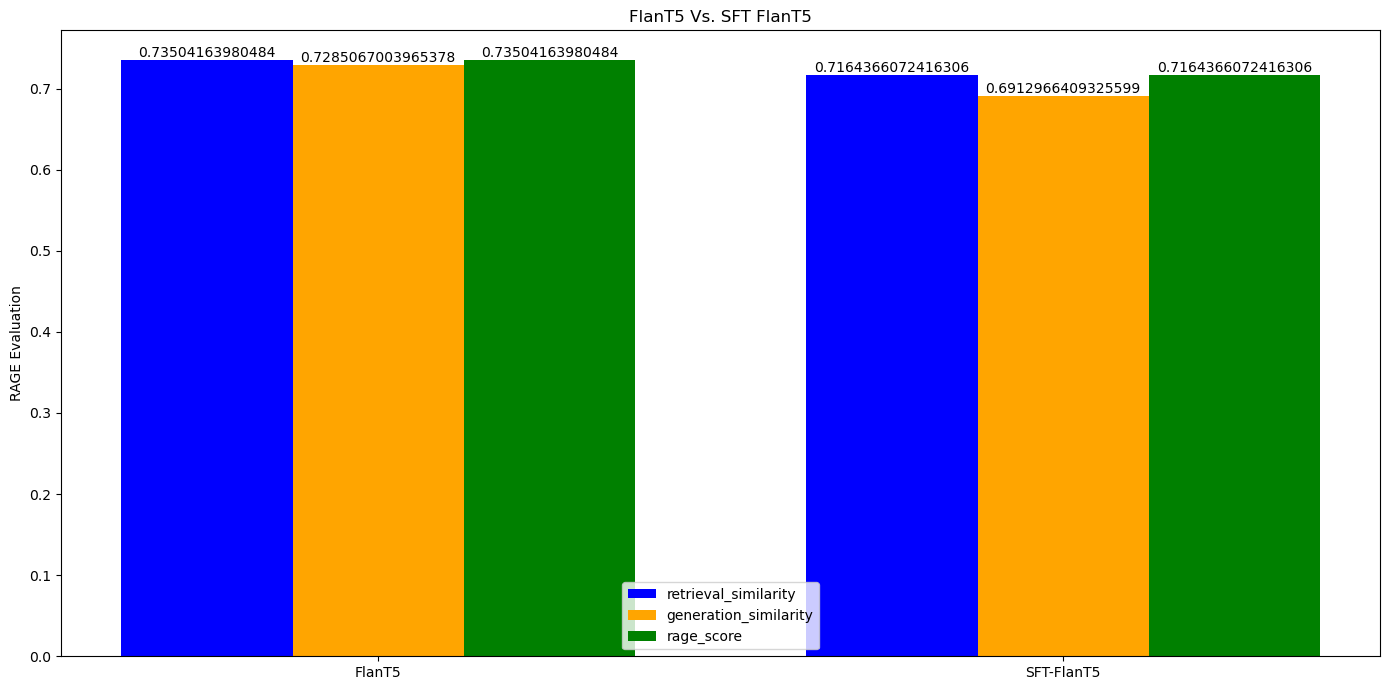

In [72]:
import matplotlib.pyplot as plt

non_rs = rage_results['retrieval_similarity'].mean()
non_gs = rage_results['generation_similarity'].mean()
non_rs = rage_results['rage_score'].mean()

finetuned_rs = rage_results_finetuned['retrieval_similarity'].mean()
finetuned_gs = rage_results_finetuned['generation_similarity'].mean()
finetuned_rs = rage_results_finetuned['rage_score'].mean()

models = ['FlanT5', 'SFT-FlanT5']
configurations = ['retrieval_similarity', 'generation_similarity', 'rage_score']

non_finetuned = [non_rs , non_gs, non_rs]
finetuned = [finetuned_rs, finetuned_gs, finetuned_rs]


# Set up the bar width and positions
bar_width = 0.25
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]


plt.figure(figsize=(14, 7))

# Function to add value labels
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}',
                 ha='center', va='bottom')

# Create and label the bars for each configuration
bars1 = plt.bar(r1, [non_finetuned[0], finetuned[0]], color='blue', width=bar_width, label=configurations[0])
bars2 = plt.bar(r2, [non_finetuned[1], finetuned[1]], color='orange', width=bar_width, label=configurations[1])
bars3 = plt.bar(r3, [non_finetuned[2], finetuned[2]], color='green', width=bar_width, label=configurations[2])

# Add the value labels
add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

plt.xlabel('')
plt.ylabel('RAGE Evaluation')
plt.title('FlanT5 Vs. SFT FlanT5')
plt.xticks([r + bar_width for r in range(len(models))], models)
plt.legend(loc='lower center')
plt.tight_layout()
plt.show()

# Speed Evaluation

### Queries Per Second (QPS)
I choosed this metric as  it gives a clear measure of the system's throughput, indicating how many queries the model can handle for a specific time interval.

### Latency
The other popular metric is latency to measure the time taken to process a single query to understand the speed of the RAG system better.

In [57]:
import time
df = pd.read_csv("finetune_dataset/test_embedding.csv")
df = df.head(50)
queries = df["Question"].tolist()


def measure_performance(queries, index, metadata, n=3):
    total_time = 0
    for query in tqdm(queries):
        start_time = time.time()
        retrieve_and_generate(query, index, metadata, n=n)
        end_time = time.time()
        total_time += end_time - start_time
    
    average_latency = total_time / len(queries)
    qps = len(queries) / total_time
    
    return average_latency, qps

n_list = [3]
qps_list = []
avg_list = []
for n in n_list:
    average_latency, qps = measure_performance(queries, index, metadata, n)
    qps_list.append(qps)
    avg_list.append(average_latency)
    

100%|███████████████████████████████████████████| 50/50 [01:34<00:00,  1.88s/it]


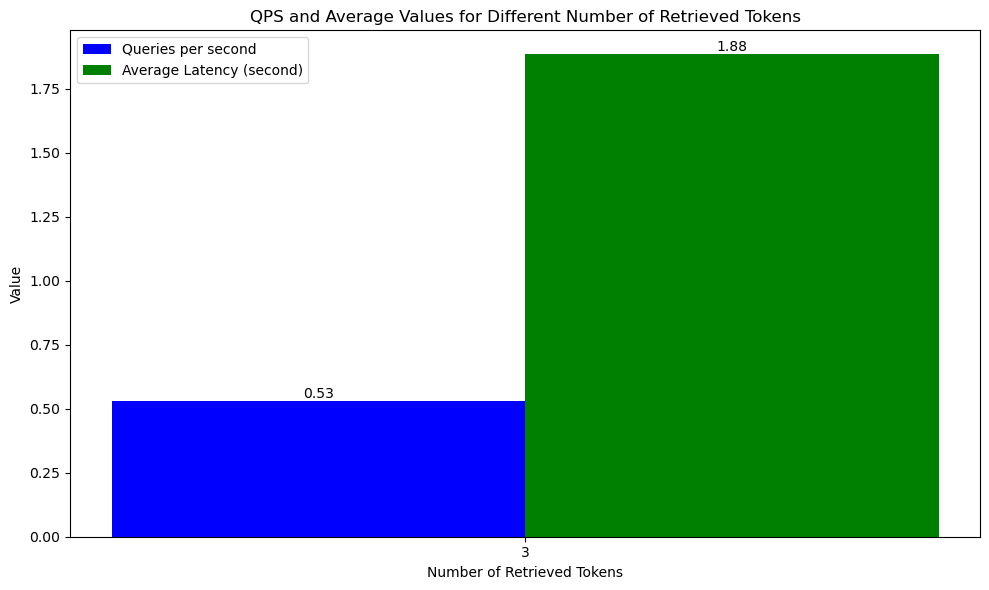

In [60]:
bar_width = 0.35
r1 = np.arange(len(n_list))
r2 = [x + bar_width for x in r1]
fig, ax = plt.subplots(figsize=(10, 6))
qps_bars = ax.bar(r1, qps_list, color='blue', width=bar_width, label='Queries per second')
avg_bars = ax.bar(r2, avg_list, color='green', width=bar_width, label='Average Latency (second)')

def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')


add_value_labels(qps_bars)
add_value_labels(avg_bars)

# Add labels and title
ax.set_xlabel('Number of Retrieved Tokens')
ax.set_ylabel('Value')
ax.set_title('QPS and Average Values for Different Number of Retrieved Tokens')
ax.set_xticks([r + bar_width/2 for r in range(len(n_list))])
ax.set_xticklabels(n_list)


ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

QUESTION: **Suppose you have to deploy the system in production that has 4x A100 GPUs to cater to 1000 users per day. Explain how you will optimize the model to achieve high speed (average response time 1-2 seconds per user), leverage multi-core processors and parallel computing to distribute tasks and accelerate inference**

# Potential Solutions for faster inference:


## Pipeline Parallelism
**Model Distribution**: to speed up, I suggest using DeepSpeed library which allows splitting the retrieval and generation models across all 4 cards. This distributes the workload, enabling parallel processing of multiple user queries at the same time.

**Model Parallelism**:Use frameworks like PyTorch DistributedDataParallel which is enabling parallel computation of different model layers.

## Tensor Parallelism
**Data Parallelism**:Implement data parallelism to process multiple batches of input simultaneously across different GPUs or nodes.

## Queueing
Implement a queueing system to store incoming user queries, and then perform batch inferencing. This would allow parallelism and also increase gpu memory. In other words, when batch created, parallel inference on all 4 GPUs would be performed. Each GPU processes its assigned queries within the batch. TRITON is a strong queueing package for nvidia gpus.

Using DP (singke processor) or Distributed DP (with unique processor for each gpu card) to copy model on different gpu (as the whole RAG model developed here is relatively small too) would also significantly speed up inference speed. 

Also other techniques like quantization, knowledge distillation can be used to serve multiple models on a single gpu car

# Potential Improvements
- Use a larger model like Llama 2 70b
- Quanizted a larger model using Optimal Brain Surgery algorithm 
- Hybrid retrival as mentioned before
- Re-ranking the retrieved documents with a cross encoder or other approaches
- Generate high qulaity dataset for SFT of LLM with the help of gpt 3.5 or other publicly availables model